In [1]:
import numpy as np 
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import json

df = pd.read_csv('astro_ph_data.csv')
df_subset = df.head(100)

def preprocess_abstract(abstract):
    abstract = abstract.lower()
    abstract = re.sub(r'[^\w\s]', '', abstract)
    return abstract

df_subset['cleaned_title'] = df_subset['title'].apply(preprocess_abstract)
df_subset['cleaned_abstract'] = df_subset['abstract'].apply(preprocess_abstract)

df_subset['cleaned_data'] = df_subset['cleaned_title'] + ' ' + df_subset['cleaned_abstract']

cleaned_data = [data for data in df_subset['cleaned_data']]

import torch
import torch.nn.functional as F

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from torch_geometric.nn import GCNConv
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_subset['cleaned_data'])

# Step 2: Create similarity matrix (Cosine Similarity)
similarity_matrix = cosine_similarity(tfidf_matrix)
adj_matrix = (similarity_matrix > 0.5).astype(int)  # Adjacency matrix based on similarity threshold

# Step 3: Convert to NetworkX graph
G = nx.from_numpy_array(adj_matrix)

# Step 4: Define Graph Autoencoder (GAE)
class GAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAE, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2(x, edge_index)

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_index)

from torch_geometric.utils import from_networkx
graph_data = from_networkx(G)

# Random input features (you can use TF-IDF vectors as node features)
graph_data.x = torch.tensor(tfidf_matrix.toarray(), dtype=torch.float)

# Step 6: Train the GAE model
model = GAE(in_channels=graph_data.num_node_features, out_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    z = model.encode(graph_data.x, graph_data.edge_index)
    loss = F.mse_loss(model.decode(z, graph_data.edge_index), torch.ones(graph_data.edge_index.size(1)))
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Step 7: Cluster the learned embeddings
model.eval()
embeddings = model.encode(graph_data.x, graph_data.edge_index).detach().numpy()

embeddings_list = embeddings.tolist()

# Define the JSON filename
embeddings_data = []
for text, embedding in zip(cleaned_data, embeddings_list):
    embeddings_data.append({
        'text': text,
        'embedding': embedding
    })

# Define the JSON filename
json_filename = "embeddings_with_text1.json"

# Save the embeddings to a JSON file
with open(json_filename, 'w') as json_file:
    json.dump(embeddings_data, json_file)

print(f"Embeddings with text saved to {json_filename}")

FileNotFoundError: [Errno 2] No such file or directory: 'astro_ph_data.csv'

In [2]:
import hashlib

def hash_value(text):
    return int(hashlib.md5(text.encode()).hexdigest(), 16)

def winnowing(text, k=5, t=4):
    # Tokenize and create n-grams of length k
    words = text.split()
    fingerprints = set()
    n_grams = [tuple(words[i:i + k]) for i in range(len(words) - k + 1)]
    hash_values = [hash_value(' '.join(n_gram)) for n_gram in n_grams]
    
    # Apply the Winnowing algorithm to get fingerprints
    for i in range(len(hash_values) - t + 1):
        window = hash_values[i:i + t]
        min_hash = min(window)
        fingerprints.add(min_hash)        
    return fingerprints


In [3]:
def compare_texts(input_text, reference_texts, k=5, t=4):
    input_fingerprints = winnowing(input_text, k, t)
    similarity_scores = {}
    
    for ref in reference_texts:
        ref_text = ref['text']
        ref_fingerprints = winnowing(ref_text, k, t)
        intersection = input_fingerprints.intersection(ref_fingerprints)
        union = input_fingerprints.union(ref_fingerprints)
        
        similarity_score = len(intersection) / len(union) if union else 0
        similarity_scores[ref_text] = similarity_score
    
    return similarity_scores


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Sample text to compare against the saved embeddings JSON data
input_text = "nallorders resummation of initialstate gluon radiation valid at\nnexttonexttoleading logarithmic accuracy the region of phase space is\nspecified in which the calculation is most reliable good agreement is\ndemonstrated with data from the fermilab tevatron and predictions are made for\nmore detailed tests with cdf and do data predictions are shown for\ndistributions of diphoton pairs produced at the energy of the large hadron\ncollider lhc distributions of the diphoton pairs from the decay of a higgs\nboson are contrasted with those produced from qcd processes at the lhc showing\nthat enhanced sensitivity to the signal can be obtained with judicious\nselection of events\n', 'the evolution of the earthmoon system based on the dark matter field\n  fluid model   the evolution of earthmoon system is described by the dark matter field\nfluid model proposed in the meeting of division of particle and field 2004\namerican physical society the current behavior of the earthmoon system agrees\nwith this model very well and the general pattern of the evolution of the\nmoonearth system described by this model agrees with geological and fossil\nevidence the closest distance of the moon to earth was about 259000 km at 45\nbillion years ago which is far beyond the roches limit the result suggests\nthat the tidal friction may not be the primary cause for the evolution of the\nearthmoon system the average dark matter field fluid constant derived from"

# Load embeddings with text from JSON file
with open('embeddings_with_text1.json', 'r') as json_file:
    embeddings_data = json.load(json_file)

# Calculate similarity scores
similarity_results = compare_texts(input_text, embeddings_data)

similarity_results

{'calculation of prompt diphoton production cross sections at tevatron and\n  lhc energies   a fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders all\nnexttoleading order perturbative contributions from quarkantiquark\ngluonantiquark and gluongluon subprocesses are included as well as\nallorders resummation of initialstate gluon radiation valid at\nnexttonexttoleading logarithmic accuracy the region of phase space is\nspecified in which the calculation is most reliable good agreement is\ndemonstrated with data from the fermilab tevatron and predictions are made for\nmore detailed tests with cdf and do data predictions are shown for\ndistributions of diphoton pairs produced at the energy of the large hadron\ncollider lhc distributions of the diphoton pairs from the decay of a higgs\nboson are contrasted with those produced from qcd processes at the lhc showing\nthat enhanced sensitivity to th

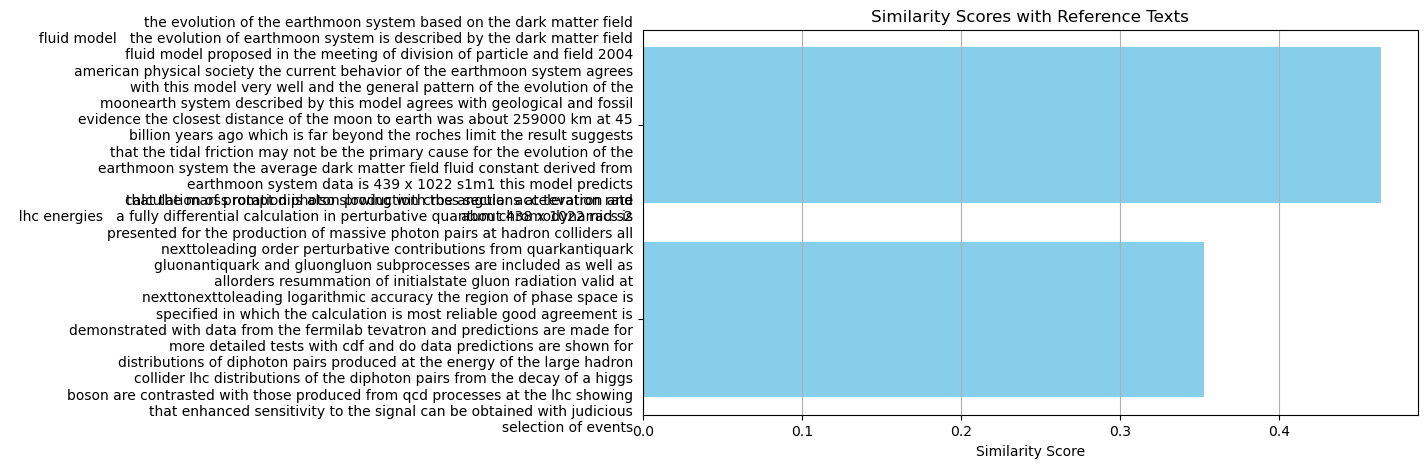

In [28]:
import pandas as pd
similarity_results = compare_texts(input_text, embeddings_data)

# Prepare data for plotting
scores = {ref_text: score for ref_text, score in similarity_results.items() if score > 0}
texts = list(scores.keys())
scores_values = list(scores.values())

# Create a DataFrame for plotting
plot_data = pd.DataFrame({'Reference Text': texts, 'Similarity Score': scores_values})

# Plot the graph as previously described
plt.figure(figsize=(10, 5))
plt.barh(plot_data['Reference Text'], plot_data['Similarity Score'], color='skyblue')
plt.xlabel('Similarity Score')
plt.title('Similarity Scores with Reference Texts')
plt.grid(axis='x')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_9936\1894978965.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


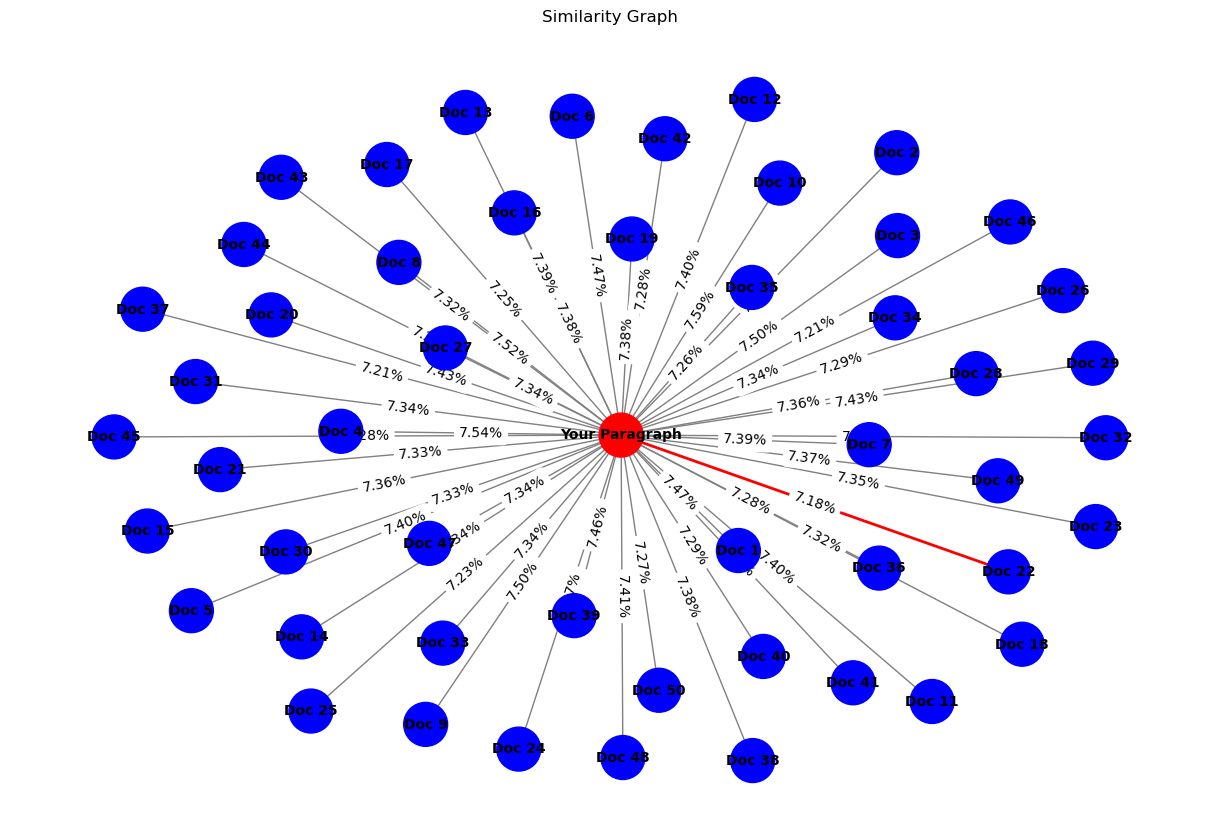

Similarity Scores (Percentage): [7.472500957919035, 7.477622671602035, 7.501625804828012, 7.535478300848553, 7.399707588193398, 7.465513894949659, 7.389573758611099, 7.515296893930149, 7.497349386816863, 7.585032172696272, 7.403015094855419, 7.3956598089216286, 7.390005918068831, 7.340847567904833, 7.364638933655461, 7.381205631599217, 7.24691323045781, 7.317194748659138, 7.383633102627402, 7.4261028162253595, 7.327340877809438, 7.175556095852631, 7.354019242051897, 7.36741222325425, 7.231658602019818, 7.285119511378511, 7.34059599585615, 7.356804587784097, 7.426503584291713, 7.332870499774694, 7.343126450995396, 7.296435092443371, 7.34447371777933, 7.343146065639299, 7.255290251763064, 7.284692294323912, 7.213796300386477, 7.382237876899637, 7.45889955274223, 7.29129909355029, 7.2921261926130665, 7.283910025221369, 7.31666655611674, 7.289891211248438, 7.283523515751533, 7.206612357795536, 7.342546691261311, 7.412913580014635, 7.367096632467618, 7.274135749754293]


In [13]:
import os
import matplotlib.pyplot as plt
import networkx as nx

from transformers import AutoTokenizer, AutoModel
import torch

input_text = "nallorders resummation of initialstate gluon radiation valid at\nnexttonexttoleading logarithmic accuracy the region of phase space is\nspecified in which the calculation is most reliable good agreement is\ndemonstrated with data from the fermilab tevatron and predictions are made for\nmore detailed tests with cdf and do data predictions are shown for\ndistributions of diphoton pairs produced at the energy of the large hadron\ncollider lhc distributions of the diphoton pairs from the decay of a higgs\nboson are contrasted with those produced from qcd processes at the lhc showing\nthat enhanced sensitivity to the signal can be obtained with judicious\nselection of events\n', 'the evolution of the earthmoon system based on the dark matter field\n  fluid model   the evolution of earthmoon system is described by the dark matter field\nfluid model proposed in the meeting of division of particle and field 2004\namerican physical society the current behavior of the earthmoon system agrees\nwith this model very well and the general pattern of the evolution of the\nmoonearth system described by this model agrees with geological and fossil\nevidence the closest distance of the moon to earth was about 259000 km at 45\nbillion years ago which is far beyond the roches limit the result suggests\nthat the tidal friction may not be the primary cause for the evolution of the\nearthmoon system the average dark matter field fluid constant derived from"


# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Generate embeddings
def generate_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()[0]


# Define a function to plot the similarity graph
def plot_similarity_graph(doc1_embedding, embeddings_data, similarity_scores_percentage, document_labels):
    # Step 1: Create a graph
    G = nx.Graph()

    # Add your paragraph as the main node (in red)
    G.add_node("Your Paragraph", color="red")

    # Add embedding paragraphs as nodes (in blue) and connect them with similarity scores
    for i, label in enumerate(document_labels):
        G.add_node(label, color="blue")  # Add dataset paragraph node
        G.add_edge("Your Paragraph", label, weight=similarity_scores_percentage[i])  # Add edge with similarity score
    
    min_similarity_score = min(similarity_scores_percentage)  # Find the minimum similarity score
    min_similarity_index = similarity_scores_percentage.index(min_similarity_score)  # Index of the min score
    min_similarity_doc = document_labels[min_similarity_index]  # Document label corresponding to min score


    # Step 2: Plot the graph
    graph_path = os.path.join('static', 'plots', 'similarity_graph.png')
    pos = nx.spring_layout(G)  # Generate graph layout

    # Node colors
    node_colors = [G.nodes[node]["color"] for node in G.nodes]

    plt.figure(figsize=(12, 8))
    nx.draw(
        G, pos, with_labels=True, node_size=1000, node_color=node_colors,
        font_size=10, font_weight="bold", edge_color="gray"
    )
    
    for edge in G.edges(data=True):
        if edge[2]['weight'] == min_similarity_score:
            nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color='red', width=2)

    # Add edge labels (similarity scores)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels={(i, j): f"{w:.2f}%" for (i, j), w in edge_labels.items()}
    )

    plt.title("Similarity Graph")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(graph_path)
    plt.show()
    plt.close()
    return graph_path



embeddings_data = [{"text": f"Paragraph {i}"} for i in range(1, 101)]  

#def generate_embedding(text):
#    return [ord(c) % 10 for c in text]  

doc1_embedding = generate_embedding(input_text)  # Your paragraph embedding

# Generate embeddings for the dataset and limit to 50 documents
doc2_embeddings = [generate_embedding(item['text']) for item in embeddings_data[:50]]

# Calculate similarity scores
def calculate_similarity(embedding1, embeddings_list):
    return [sum([abs(a - b) for a, b in zip(embedding1, e)]) / len(embedding1) for e in embeddings_list]

similarity_scores = calculate_similarity(doc1_embedding, doc2_embeddings)
similarity_scores_percentage = [max(0, 10 - score * 10) for score in similarity_scores]  # Convert to percentage and ensure no negative values

# Generate document labels (limited to 50)
document_labels = [f"Doc {i+1}" for i in range(len(similarity_scores_percentage))]

# Plot similarity graph (for 50 documents)
graph_path = plot_similarity_graph(doc1_embedding, embeddings_data[:50], similarity_scores_percentage, document_labels)

# Print similarity scores for verification
print("Similarity Scores (Percentage):", similarity_scores_percentage)
